# 目录
1. [EncoderDecoder Network](#EncoderDecoder-Network)
2. [Attention机制](#Attention机制)
3. [西班牙语-英语翻译示例](#西班牙语-英语翻译示例)

# [EncoderDecoder Network](#目录)

Encoder-Decoder Network，如下图所示
- 英文句子输入到 encoder 中，decoder 输出法文句子。
- 英文句子是逆序提供给 encoder 的：“I drink milk”--->“milk drink I”，保证句首最后提供给 encoder，因为 decoder 是最先翻译句首
- 目标法文句子也是 decoder 的输入，但后移一步；句首为 `<sos>` (start of sequence)标志，句尾为 `<eos>` 标志。
- decoder 每一步先输出词汇表中所有单词的 score，然后 softmax 层转化为概率，概率最高的单词即为结果；sparse_categorical_crossentropy 损失函数
- 推理阶段，没有目标句子，decoder 每一步的输入是其上一步的输出，初始为 `<sos>` 标志

<img src="../images/neural_machine_translation.jpg" width="80%" alt="简单机器翻译模型">

- encoder 的输入序列长度不定，decoder 的输入序列也如此：
    - 输入序列的长度差别不是很大，可使用 masking
    - 否则，将序列分组进 buckets，如一个 bucket 用于1-6个单词的句子、另一 bucket 用于7-12单词的句子；然后使用 padding，如“I drink milk”--->“`<pad> <pad> <pad> milk drink I`”；tf.data.experimental.bucket_by_sequence_length() 函数
- 忽略输出序列 `<eos>` 标志后的内容
- 当输出的词汇表太大时，计算其中所有单词的概率太耗费计算资源；可以仅仅选择正确单词即随机采样的错误单词，tf.nn.sampled_softmax 函数；但仅仅在训练时，如此操作，推理阶段应是正常的 softmax 函数

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# import tensorflow_addons as tfa

In [3]:
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

In [4]:
vocab_size, embed_size = 10000, 200

In [6]:
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

In [7]:
encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

In [ ]:
sampler = tfa.seq2seq.sampler.TrainingSampler()

In [ ]:
decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tf1.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler, output_layer = output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(decoder_embeddings, 
                                                             initial_state=encoder_state,
                                                            sequence_lengths=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
                   outputs=[Y_proba])

- 双向 RNN
- Beam Search

# [Attention机制](#目录)

![](../images/attention_mechanism.jpg)

Attention 计算流程
1. 给定 Encoder 的隐藏状态：$h_1, h_2, ... h_N \in R^{d_1}$
2. 在 Decoder 的时间 t，其隐藏状态为 $s_t \in R^{d_2}$
3. 求该时间步的 attention scores:
$e^t = [s_t^Th_1, s_t^Th_2, ..., s_t^Th_N]$
4. 求得 attention 分布：$\alpha^t=softmax(e^t)$
5. attention 输出为：$a_t = \sum_{i=1}^{N}\alpha^t_ih_i$
6. 连接 $s_t$ 和 $a_t$：$[a_t;s_t]$

`tf.keras.layers.Attention`：
- 输入：
    - `query, shape=[batch_size, Tq, dim]`;
    - `value, shape=[batch_size, Tv, dim]`;
    - `key, shape=[batch_size, Tv, dim]`
- 计算过程：
    - `scores = tf.matmul(query, key, transpose_b=True), shape=[batch_size, Tq, Tv]`
    - `distribution = tf.nn.softmax(scores)`
    - `return tf.matmul(distribution, value), shape=[batch_size, Tq, dim]`

### Attention+CNN

In [ ]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(max_tokens, dimension)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(query_input)

# CNN layer.
cnn_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    # Use 'same' padding so outputs have the same shape as inputs.
    padding='same')
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = cnn_layer(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])

# Add DNN layers, and create Model.
# ...


# [西班牙语-英语翻译示例](#目录)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### 1、数据集预处理
1. 每句话添加 start 及 end 标志
2. 删除特殊字符
3. word2id 及 id2word
4. 每句话 pad 为最大长度

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [7]:
len(en),len(sp)

(118964, 118964)

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

#### 选择数据集中的 30000 句作为示例

In [11]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)


In [16]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


24000 24000 6000 6000


In [18]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [19]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6 ----> ¿
60 ----> donde
88 ----> hay
15 ----> un
1166 ----> hospital
5 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
71 ----> where
8 ----> is
9 ----> a
1007 ----> hospital
7 ----> ?
2 ----> <end>


#### tf.data 对象

In [20]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

### 2、创建 encoder-decoder 模型
约定：
- FC = Fully connected (dense) layer
- EO = Encoder output
- H = hidden state
- X = input to the decoder
       
伪代码：
- `score = FC(tanh(FC(EO) + FC(H)))`
- `attention weights = softmax(score, axis = 1)`
- `context vector = sum(attention weights * EO, axis = 1)`
- `merged vector = concat(embedding output, context vector)`


![](../images/attention_mechanism.jpg)

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True,
                                       return_state=True, 
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [36]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)
        
         # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

         # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [37]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [38]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [39]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (64, 4935)


### 3、训练模型

In [40]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [42]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [43]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Loss 2.0338
Time taken for 1 epoch 1002.6916968822479 sec

Epoch 2 Loss 1.3765
Time taken for 1 epoch 900.9487726688385 sec

Epoch 3 Loss 0.9524
Time taken for 1 epoch 869.3331334590912 sec

Epoch 4 Loss 0.6402
Time taken for 1 epoch 971.220751285553 sec

Epoch 5 Loss 0.4374
Time taken for 1 epoch 939.8397359848022 sec

Epoch 6 Loss 0.3069
Time taken for 1 epoch 794.041389465332 sec

Epoch 7 Loss 0.2187
Time taken for 1 epoch 743.7652299404144 sec

Epoch 8 Loss 0.1648
Time taken for 1 epoch 748.7127416133881 sec

Epoch 9 Loss 0.1285
Time taken for 1 epoch 745.3105812072754 sec

Epoch 10 Loss 0.1058
Time taken for 1 epoch 746.6278686523438 sec



### 4、评估

In [44]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [45]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [46]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


In [47]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


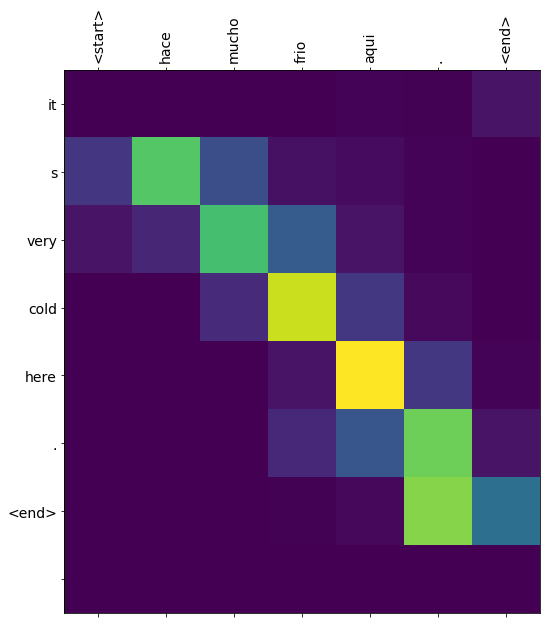

In [48]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


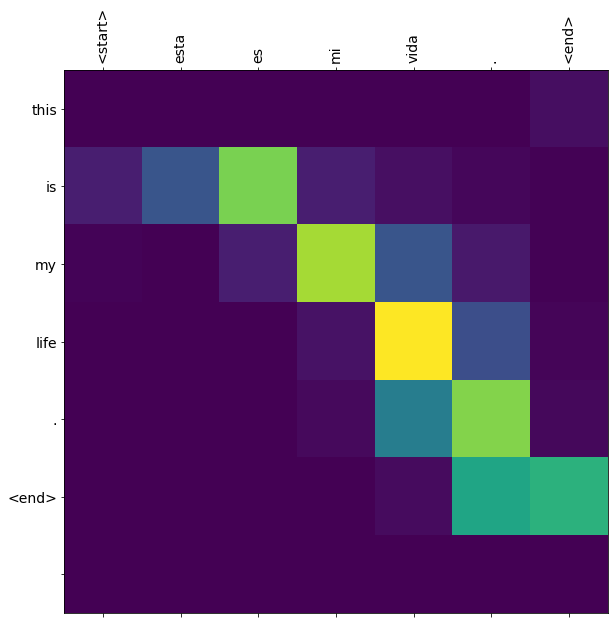

In [49]:
translate(u'esta es mi vida.')